# Documents Extraction

In [177]:
import os
import re
import pickle
import string
import numpy as np
import pandas as pd
from ParserCACM import *
from IndexerQuery import *
from porter import *
from copy import *
from nltk.corpus import stopwords
from TextRepresenter import PorterStemmer
from ggplot import *
from porter import *

In [62]:
# Processed collections 
collectionPath = 'data/cacm/cacm.txt'
collectionPath2 = 'data/cisi/cisi.txt'

In [63]:
parser = ParserCACM()
parser.initFile(collectionPath)
docExample = parser.nextDocument()
print(docExample)

id=1
 Preliminary Report-International Algebraic Language 
  Perlis, A. J. Samelson,K. 
  
 
{'from': '/home/mcrilo33/Master/Master2/RI/TP1/data/cacm/cacm.txt;0;402', 'links': '100;123;164;205;210;214;1982;398;642;669;165;196;196;1273;1883;324;43;53;91;410;3184;', 'author': ' Perlis, A. J. Samelson,K.', 'text': '', 'title': ' Preliminary Report-International Algebraic Language', 'keywords': ''}


# Documents Indexing

In [64]:
class Indexer(object):
    '''Build an Index from a Collection'''
    
    def __init__(
        self, collectionPath,
        parser,
        fromCol="",
        repPath="",
        repIndexPath="",
        repInvPath="",
        repInvIndexPath="",
        repInvFromAllPath="",
        linkPath="",
        linkIndexPath=""
    ):
        
        # parser is a Parser object
        self.parser = parser
                 
        # collectionPath is a String object
        self.collectionPath = collectionPath
        end = re.search(r'\..*?$', collectionPath).group(0)
                 
        # Path names
        if repPath=="":
            self.repPath = \
                re.sub(r'\..*$', 'Rep'+end, self.collectionPath)
        else:
            self.repPath = repPath
        if fromCol=="":
            self.fromCol = \
                re.sub(r'\..*$', 'Index'+end, self.collectionPath)
        else:
            self.fromCol = fromCol
        if repIndexPath=="":
            self.repIndexPath = \
                re.sub(r'\..*$', 'Index'+end, self.repPath)
        else:
            self.repIndexPath = repindexPath
        if repInvIndexPath=="":
            self.repInvIndexPath = \
                re.sub(r'\..*$', 'InvIndex'+end, self.repPath)
        else:
            self.repInvIndexPath = repInvIndexPath
        if repInvFromAllPath=="":
            self.repInvFromAllPath = \
                re.sub(r'\..*$', 'InvFromAll'+end, self.repPath)
        else:
            self.repInvFromAllPath = repInvFromAllPath
        if repInvPath=="":
            self.repInvPath = re.sub(r'\..*$', 'Inv'+end, self.repPath)
        else:
            self.repInvPath
        if linkPath=="":
            self.linkPath = re.sub(r'\..*$', 'Link'+end, self.collectionPath)
        else:
            self.linkPath
        if linkIndexPath=="":
            self.linkIndexPath = re.sub(r'\..*$', 'LinkIndex'+end, self.collectionPath)
        else:
            self.linkIndexPath
        
        # Loads Hashtables if they exist
        if os.path.isfile(self.repIndexPath):
            repIndexFile = open(self.repIndexPath)
            self.index = pickle.load(repIndexFile)
            repIndexFile.close()
        else:
            self.index = {}
        if os.path.isfile(self.fromCol):
            fromColFile = open(self.fromCol)
            self.indexFromCol = pickle.load(fromColFile)
            fromColFile.close()
        else:
            self.indexFromCol = {}
        if os.path.isfile(self.repInvIndexPath):
            repInvIndexFile = open(self.repInvIndexPath)
            self.invIndex = pickle.load(repInvIndexFile)
            repInvIndexFile.close()
        else:
            self.invIndex = {}
        if os.path.isfile(self.repInvFromAllPath):
            repInvFromAllFile = open(self.repInvFromAllPath)
            self.repInvFromAll = pickle.load(repInvFromAllFile)
            repInvFromAllFile.close()
        else:
            self.repInvFromAll = {}
        if os.path.isfile(self.linkIndexPath):
            linkIndexFile = open(self.linkIndexPath)
            self.linkIndex = pickle.load(linkIndexFile)
            linkIndexFile.close()
        else:
            self.linkIndex = {}
            
        self.elements = {} # elements in self for optimisation reasons
        
    def __filters(self, doc):
        '''Filters applied to each document of the collection'''
        
        return True
    
    def __getData(self, rep, index, id):
        '''Return Something frequencies from a rep and his index at id==id'''
        
        id = str(id)
        
        if index=={}:
            raise ValueError('Index undefined')
        if not(os.path.isfile(rep)):
            raise ValueError('Rep file does no exist')
        if not(id in index):
            raise ValueError('Bad Identifier')
             
        pos = index[id]
        repFile = open(rep, 'r')
        repFile.seek(pos[0])
        rep = repFile.read(pos[1])
        repFile.close()
        
        return rep
        
    def __freqFromData(self, data):
    
        freq = {}
        total = 0
        rep = data.split(':')
        
        for i in range(0, len(rep), 2):
            added = int(rep[i+1])
            freq[rep[i]] = added
            total += added
        freq[-1] = total
        
        return freq
    
    def __updatePosElements(self, doc):
        '''Update pos and size of each element in inv index'''
        
        elements = self.elementsFromDoc(doc)
        id = len(doc.getId())
        
        for element in elements:
            
            added = id+len(str(elements[element]))+2
            if element in self.elements:
                self.elements[element] += added
            else:
                self.elements[element] = added-1
            
        return self.elements
    
    def elementsFromDoc(self, doc):
        '''Return an hashtable of the count of each element in a doc'''
        
        raise ValueError('Abstract method')
    
    def getEfFromDoc(self, id):
        '''Return the element frequencies of a doc with identifier==id'''
        
        data = self.__getData(self.repPath, self.index, str(id))
        return self.__freqFromData(data)
            
    def getDfFromEl(self, element):
        '''Return the document frequencies of an element'''
        
        data = self.__getData(self.repInvPath, self.invIndex, str(element))
        return self.__freqFromData(data)
        
    def getLinkFromDoc(self, id):
        '''Return the links of a document'''
        
        return self.__getData(self.linkPath, self.linkIndex, str(id)).split(";")
    
    def getStrFromDoc(self, id):
        '''Return the string of a doc with identifier==id in Col'''
        
        return self.__getData(self.collectionPath, self.indexFromCol, str(id))
    
    def getObjFromDoc(self, id):
        '''Return the object of a doc with identifier==id in Col'''
        
        return self.parser.getDocument(self.getStrFromDoc(id))
    
    def createIndex(self):
        
        self.parser.initFile(self.collectionPath)
        posCol = self.parser.file.tell()
        doc = self.parser.nextDocument()
        self.indexFromCol = {}
        
        while doc!=None:
            
            posCol2 = self.parser.file.tell()
        
            if self.__filters(doc)==True:
                # Get pos in col and size of current doc
                self.indexFromCol[doc.getId()] = [posCol, posCol2-posCol]
                
            doc = self.parser.nextDocument()
            posCol = posCol2
            
        # Indexes'hashtable of doc in col
        fromCol = open(self.fromCol, "w")
        pickle.dump(self.indexFromCol, fromCol)
        
        fromCol.close()
        
    def createRepIndex(self):
            
        self.parser.initFile(self.collectionPath)
        posCol = self.parser.file.tell()
        doc = self.parser.nextDocument()
        repFile = open(self.repPath, "w")
        pos = 0
        self.index = {}
        self.indexFromCol = {}
        
        while doc!=None:
            
            posCol2 = self.parser.file.tell()
            
            if self.__filters(doc)==True:
                # Get rep of current doc
                elements = self.elementsFromDoc(doc)
                toWrite = ''
                for element in elements:
                    toWrite += ':'+element+':'+str(elements[element])
                toWrite = toWrite[1:]
                # Get pos in index and size of current rep
                self.index[doc.getId()] = [pos, len(toWrite)]
                # Get pos in col and size of current doc
                self.indexFromCol[doc.getId()] = [posCol, posCol2-posCol]
                
                repFile.write(toWrite)
                pos += len(toWrite)
                
            doc = self.parser.nextDocument()
            posCol = posCol2
            
        repFile.close()
        
        # Indexes'hashtable of rep
        repIndexFile = open(self.repIndexPath, "w")
        pickle.dump(self.index, repIndexFile)
        # Indexes'hashtable of doc in col
        fromCol = open(self.fromCol, "w")
        pickle.dump(self.indexFromCol, fromCol)
        
        repIndexFile.close()
        fromCol.close()
        
    def createRepInvIndex(self):
        
        # First pass
        self.parser.initFile(self.collectionPath)
        doc = self.parser.nextDocument()
        self.elements = {}
        self.invIndex = {}
        
        while doc!=None:
            
            if self.__filters(doc)==True:
                # Updates pos and size of each element in inv index
                self.__updatePosElements(doc)
                
            doc = self.parser.nextDocument()
            
        # Get pos and size of each elements from there size in inv index
        cumsum = 0
        for element in self.elements:
            tmp = self.elements[element]
            self.elements[element] = [cumsum, tmp]
            cumsum += tmp

        # Indexes'hashtable of elements in inv index
        for element in self.elements:
            self.invIndex[element] = self.elements[element]
        repInvIndexFile = open(self.repInvIndexPath, "w")
        pickle.dump(self.invIndex, repInvIndexFile)
        repInvIndexFile.close()
        
        # Second pass
        repInvFile = open(self.repInvPath, "w")
        self.parser.initFile(self.collectionPath)
        doc = self.parser.nextDocument()
        
        while doc!=None:
            
            if self.__filters(doc)==True:
                elements = self.elementsFromDoc(doc)
                toWrite = ''
                for element in elements:
                    toWrite = doc.getId()+':'+str(elements[element])+':'
                    repInvFile.seek(self.elements[element][0])
                    if (self.elements[element][1]-len(toWrite)) < 0:
                        toWrite = toWrite[:-1]
                    repInvFile.write(toWrite)
                    self.elements[element][0] += len(toWrite)
                    self.elements[element][1] -= len(toWrite)
                    
            doc = self.parser.nextDocument()
        
        repInvIndexFile = open(self.repInvIndexPath)
        self.invIndex = pickle.load(repInvIndexFile)
        repInvIndexFile.close()
        repInvFile.close()
        
    def createRepInvFromAll(self):
        
        if self.index == {}:
            raise ValueError('Rep index undefined')
            
        if self.invIndex == {}:
            raise ValueError('Rep invIndex undefined')
            
        self.repInvFromAll = {}
        
        for element in self.invIndex:
            docs = self.getDfFromEl(element)
            docs.pop(-1)
            self.repInvFromAll[element] = np.sum([docs[doc] for doc in docs])
        
        self.repInvFromAll[-1] = 0
        for id in self.index:
            freq = self.getEfFromDoc(id)
            self.repInvFromAll[-1] += freq[-1]
                
        # Indexes'hashtable of doc in col
        repInvFromAllFile = open(self.repInvFromAllPath, "w")
        pickle.dump(self.repInvFromAll, repInvFromAllFile)

        repInvFromAllFile.close()
                
    def createLinkIndex(self):
        
        if self.index == {}:
            raise ValueError('Rep index undefined')
            
        if self.indexFromCol == {}:
            raise ValueError('Rep invIndex undefined')
        
        self.linkIndex = {}
        
        linkFile = open(self.linkPath, "w")
        pos = linkFile.tell()
        
        for id in self.index:
            
            doc = self.getObjFromDoc(id)
            links = doc.get('links')[:-1]
            linkFile.write(links)
            pos2 = linkFile.tell()
            self.linkIndex[id] = [pos, pos2-pos]
            pos = pos2
            
        linkFile.close()
        
        linkIndexFile = open(self.linkIndexPath, "w")
        pickle.dump(self.linkIndex, linkIndexFile)
        linkIndexFile.close()
            

In [65]:
class IndexerCACM(Indexer):
    
    def __init__(self, collectionPath, parser):
        
        Indexer.__init__(self, collectionPath, parser)
        
    def elementsFromDoc(self, doc):
        
        elements = {}
        text = doc.getText()
        stop_words = set(stopwords.words('english'))

        # preprocessing
        text = text.lower()
        text = re.sub(r'(!|#|"|%|\$|\'|&|\)|\(|\+|\*|(^| )(-( |$))+|,|/|\.|;|:|=|<|\?|>|@|[|]|\|_|^|`|{|}|\||~)', ' ', text)
        text = re.sub(r'\n', ' ', text)
        text = re.sub(r'\d+', '', text)
        text = re.sub(r'(^| )(\w($| ))+', ' ', text)
        text = re.sub(r' +', ' ', text)
        
        stemmer = PorterStemmer()

        return stemmer.getTextRepresentation(text)
 

## Demo

### Constructions of Index and Inversed Index

In [66]:
indexer = IndexerCACM(collectionPath, ParserCACM())

# If Index and Inv Index aren't already builded
#indexer.createRepIndex()
#indexer.createRepInvIndex()
#indexer.createRepInvFromAll()
#indexer.createLinkIndex()

print(indexer)

### Get string from document

In [67]:
print(indexer.getStrFromDoc(111))

.I 111
.T
On Programming the Numerical Solution of Polynomial Equations
.W
Numerical techniques are presented for computing
the roots of polynomial equations.  By applying 
the recommended scaling and inversion rules, the basic
Bairstow and Newton-Raphson iterative techniques 
can be applied with great reliability.  Both a high degree
of accuracy and rapid convergence are realized. 
 Numerical examples are shown to illustrate the pitfalls
and to show how these are circumvented by application 
of the recommended procedures.
.B
CACM December, 1960
.A
Ellenberger, K. W.
.N
CA601205 JB March 20, 1978  6:41 PM
.X
111	5	111
111	5	111
111	5	111




### Get obj from Doc

In [53]:
obj = indexer.getObjFromDoc(20)
print(obj.getText())

 Accelerating Convergence of Iterative Processes 
  Wegstein, J. H. 
  
  A technique is discussed which, when applied to an iterative procedure for the solution of an equation, accelerates the rate of convergence if the iteration converges and induces convergence if the iteration diverges.  An illustrative example is given.


### Get element frequencies from document

In [54]:
print(indexer.getEfFromDoc(20))

{'acceler': 1, 'techniqu': 1, 'process': 1, 'appli': 1, 'induc': 1, 'accelerat': 1, 'solut': 1, 'wegstein': 1, 'procedur': 1, 'converg': 4, 'rate': 1, 'exampl': 1, 'iter': 4, 'illustr': 1, 'diverg': 1, 'discuss': 1, -1: 23, 'equat': 1}


### Get document frequencies from element

In [49]:
print(indexer.getDfFromEl('a'))

{'1665': 3, '1552': 2, -1: 5}


# Queries Indexing

### Queries Indexer

In [39]:
queriesPath = 'data/cacm/cacm.qry'
parser = ParserCACM()
queriesIndexer = IndexerCACM(queriesPath, ParserCACM())

# If Index isn't already builded
queriesIndexer.createRepIndex()
print(queriesIndexer.indexFromCol)

{'56': [11573, 146], '54': [11134, 290], '42': [8905, 189], '48': [10140, 285], '43': [9094, 212], '60': [12677, 325], '61': [13002, 258], '62': [13260, 138], '63': [13398, 143], '64': [13541, 144], '49': [10425, 120], '52': [10728, 84], '53': [10812, 322], '24': [3968, 87], '25': [4055, 104], '26': [4159, 110], '27': [4269, 102], '20': [3323, 126], '21': [3449, 186], '22': [3635, 225], '23': [3860, 108], '46': [9709, 198], '47': [9907, 233], '44': [9306, 136], '45': [9442, 267], '28': [4371, 263], '29': [4634, 165], '40': [8091, 328], '41': [8419, 486], '1': [0, 169], '3': [347, 150], '2': [169, 178], '5': [918, 294], '4': [497, 421], '7': [1415, 311], '6': [1212, 203], '9': [1871, 149], '8': [1726, 145], '51': [10655, 73], '39': [7811, 280], '38': [7529, 282], '59': [12422, 255], '58': [12122, 300], '11': [2147, 96], '10': [2020, 127], '13': [2322, 94], '12': [2243, 79], '15': [2596, 192], '14': [2416, 180], '17': [2960, 108], '16': [2788, 172], '19': [3243, 80], '18': [3068, 175], '

### Relevant Indexer

In [36]:
class RelevantParser(Parser):

    def __init__(self):
        
        Parser.__init__(self, '')
        self.curId = None
    
    def nextDocument(self):
        
        if self.curId==None:
            self.curLine = self.file.readline()
            if self.curLine!=None:
                self.curId = ((self.curLine).split())[0]
            
        id = self.curId
        text = ''
        
        while(id==self.curId and self.curLine!=''):
            text += self.curLine
            pos = self.file.tell()
            self.curLine = self.file.readline()
            if self.curLine!='':
                self.curId = ((self.curLine).split())[0]
        if self.curLine!='':
            self.file.seek(pos)
        
        if text=='':
            return None
        
        return self.getDocument(text)
        
    def getDocument(self, text):
        
        tab = \
        [
            [str(int((i.split())[1])), int((i.split())[2]), int((i.split())[3])] \
            for i in text.split('\n')[:-1] \
        ]
        identifier = str(int(text.split()[0]))
        
        return Document(identifier, others={'tab': tab})


In [37]:
relevantPath = 'data/cacm/cacm.rel'
relevantIndexer = Indexer(relevantPath, RelevantParser())

# If Index and Inv Index aren't already builded
relevantIndexer.createIndex()

In [38]:
print(relevantIndexer.indexFromCol)

{'42': [6612, 252], '48': [7872, 144], '43': [6864, 492], '60': [9000, 324], '61': [9324, 372], '62': [9696, 96], '63': [9792, 144], '64': [9936, 12], '49': [8016, 96], '24': [3712, 169], '25': [3881, 663], '26': [4544, 390], '27': [4934, 377], '20': [3267, 36], '21': [3303, 143], '22': [3446, 214], '23': [3660, 52], '44': [7356, 204], '45': [7560, 312], '28': [5311, 64], '29': [5375, 247], '40': [6492, 120], '1': [0, 65], '3': [104, 78], '2': [65, 39], '5': [338, 101], '4': [182, 156], '7': [478, 364], '6': [439, 39], '9': [879, 113], '8': [842, 37], '39': [6348, 144], '38': [6156, 192], '59': [8484, 516], '58': [8124, 360], '11': [1447, 247], '10': [992, 455], '13': [1759, 143], '12': [1694, 65], '15': [2450, 126], '14': [1902, 548], '17': [2784, 208], '16': [2576, 208], '19': [3135, 132], '18': [2992, 143], '31': [5674, 26], '30': [5622, 52], '37': [6012, 144], '36': [5752, 260], '33': [5739, 13], '32': [5700, 39], '57': [8112, 12]}


### Query Object

In [40]:
class Query(object):

    def __init__(self, id, text="", el=None, relevants=None):
        
        self.id = id
        self.text = text
        self.el = el
        self.relevants = relevants
        
def query(id, queriesIndexer, relevantIndexer):
    
    id = str(id)
    text = queriesIndexer.getObjFromDoc(id).getText()
    el = queriesIndexer.getEfFromDoc(id)
    relevants = relevantIndexer.getObjFromDoc(id).get('tab')
    
    return Query(id, text, el, relevants)

In [41]:
q = query(5, queriesIndexer, relevantIndexer)
print('Id : ', q.id)
print('Text : ', q.text)
print('Elements : ', q.el)
print('Relevants : ', q.relevants)

('Id : ', '5')
('Text : ', " \n  \n  \n   I'd like papers on design and implementation of editing interfaces, window-managers, command interpreters, etc.  The essential issues are human interface design, with views on improvements to user efficiency, effectiveness and satisfaction.")
('Elements : ', {-1: 20, 'effici': 1, 'satisfact': 1, 'essenti': 1, 'command': 1, 'effect': 1, 'issu': 1, 'edit': 1, 'window': 1, 'paper': 1, 'design': 2, 'user': 1, 'human': 1, 'interfac': 2, 'improv': 1, 'implement': 1, 'manag': 1, 'interpret': 1, 'view': 1})
('Relevants : ', [['756', 0, 0], ['1307', 0, 0], ['1502', 0, 0], ['2035', 0, 0], ['2299', 0, 0], ['2399', 0, 0], ['2501', 0, 0], ['2820', 0, 0]])


### Analysis of the collection

In [171]:
print('Size of vocabulary', len(indexer.invIndex))
d = copy(indexer.repInvFromAll)
d.pop(-1)
data = pd.DataFrame(d, index=[0])
data = pd.melt(data)

('Size of vocabulary', 7620)


#### Stemmer critic

In [180]:
print(stem('typographical'), stem('typographic'))

('typographical', 'typographic')


#### Vocabulary

In [172]:
data.sort(columns='value')

/home/mcrilo33/.anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,variable,value
6955,traine,1
7079,typographical,1
7078,typographic,1
5417,quasiliner,1
4538,noncyclic,1
4540,nondegener,1
5401,quadrilater,1
4568,nonoverlapp,1
4576,nonprefer,1
4580,nonprofession,1


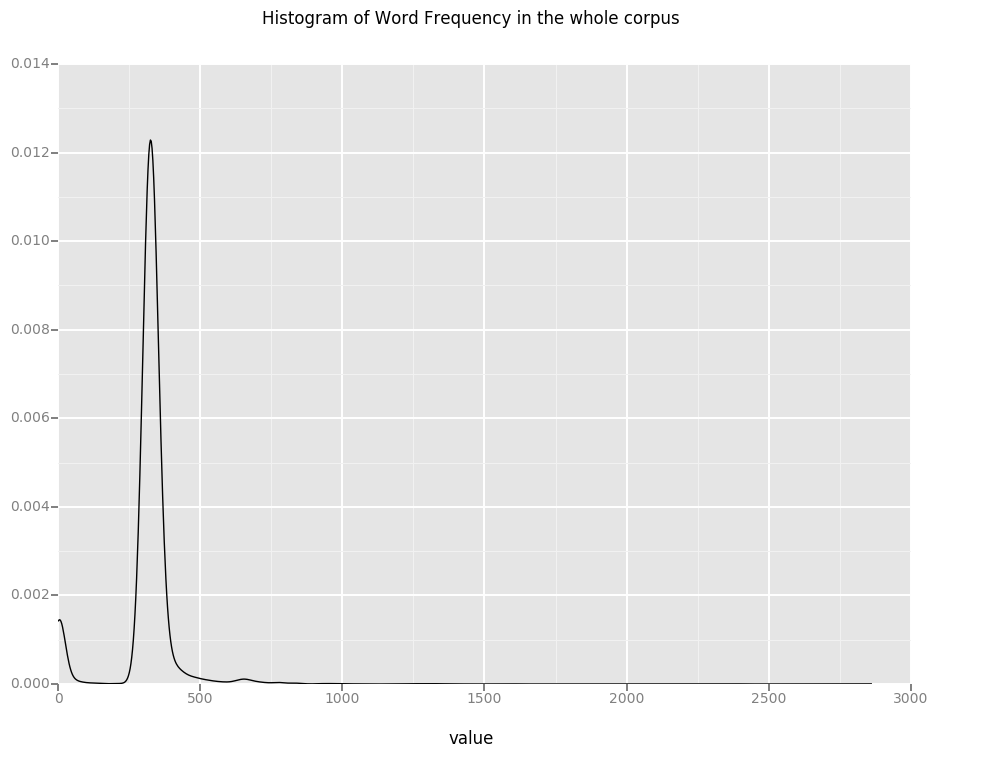

<ggplot: (8749299102953)>

In [174]:
ggplot(aes(x='value'), data=data) + \
    geom_density() + \
    ggtitle('Histogram of Word Frequency in the whole corpus')